In [3]:
import matplotlib.pyplot as plot
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm
import numpy as np
import pandas as pd
from sklearn import preprocessing
from pandas import DataFrame
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

                            乙基红浓度      Time/sec  Melting point  Boiling point  \
乙基红浓度                1.000000e+00 -3.420823e-17   1.317118e-01   2.117610e-01   
Time/sec            -3.420823e-17  1.000000e+00   9.451092e-17   6.258744e-17   
Melting point        1.317118e-01  9.451092e-17   1.000000e+00   9.149667e-01   
Boiling point        2.117610e-01  6.258744e-17   9.149667e-01   1.000000e+00   
ExactMolWt           2.575862e-01 -7.493380e-17   3.686622e-01   4.777362e-01   
FractionCSP3         1.821299e-01  5.787193e-18  -1.938902e-01   2.182576e-01   
HallKierAlpha        1.572630e-01  7.109219e-17  -3.105523e-01   9.830103e-02   
HeavyAtomCount       2.293008e-01 -1.435025e-16   3.409789e-01   4.016006e-01   
HeavyAtomMolWt       2.664716e-01 -1.287185e-16   4.591111e-01   5.504532e-01   
Ipc                 -1.776508e-02 -8.692974e-17   1.174113e-01   2.022376e-01   
Kappa1               2.444979e-01 -5.650831e-17   2.866018e-01   4.031717e-01   
Kappa2               3.70396

D:\ProgramData\Anaconda3\envs\py37\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 20057 (\N{CJK UNIFIED IDEOGRAPH-4E59}) missing from current font.
  fig.canvas.draw()
D:\ProgramData\Anaconda3\envs\py37\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 22522 (\N{CJK UNIFIED IDEOGRAPH-57FA}) missing from current font.
  fig.canvas.draw()
D:\ProgramData\Anaconda3\envs\py37\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 32418 (\N{CJK UNIFIED IDEOGRAPH-7EA2}) missing from current font.
  fig.canvas.draw()
D:\ProgramData\Anaconda3\envs\py37\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 27987 (\N{CJK UNIFIED IDEOGRAPH-6D53}) missing from current font.
  fig.canvas.draw()
D:\ProgramData\Anaconda3\envs\py37\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  fig.canvas.draw()
D:\ProgramData\Anaconda3\envs\py37\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 2

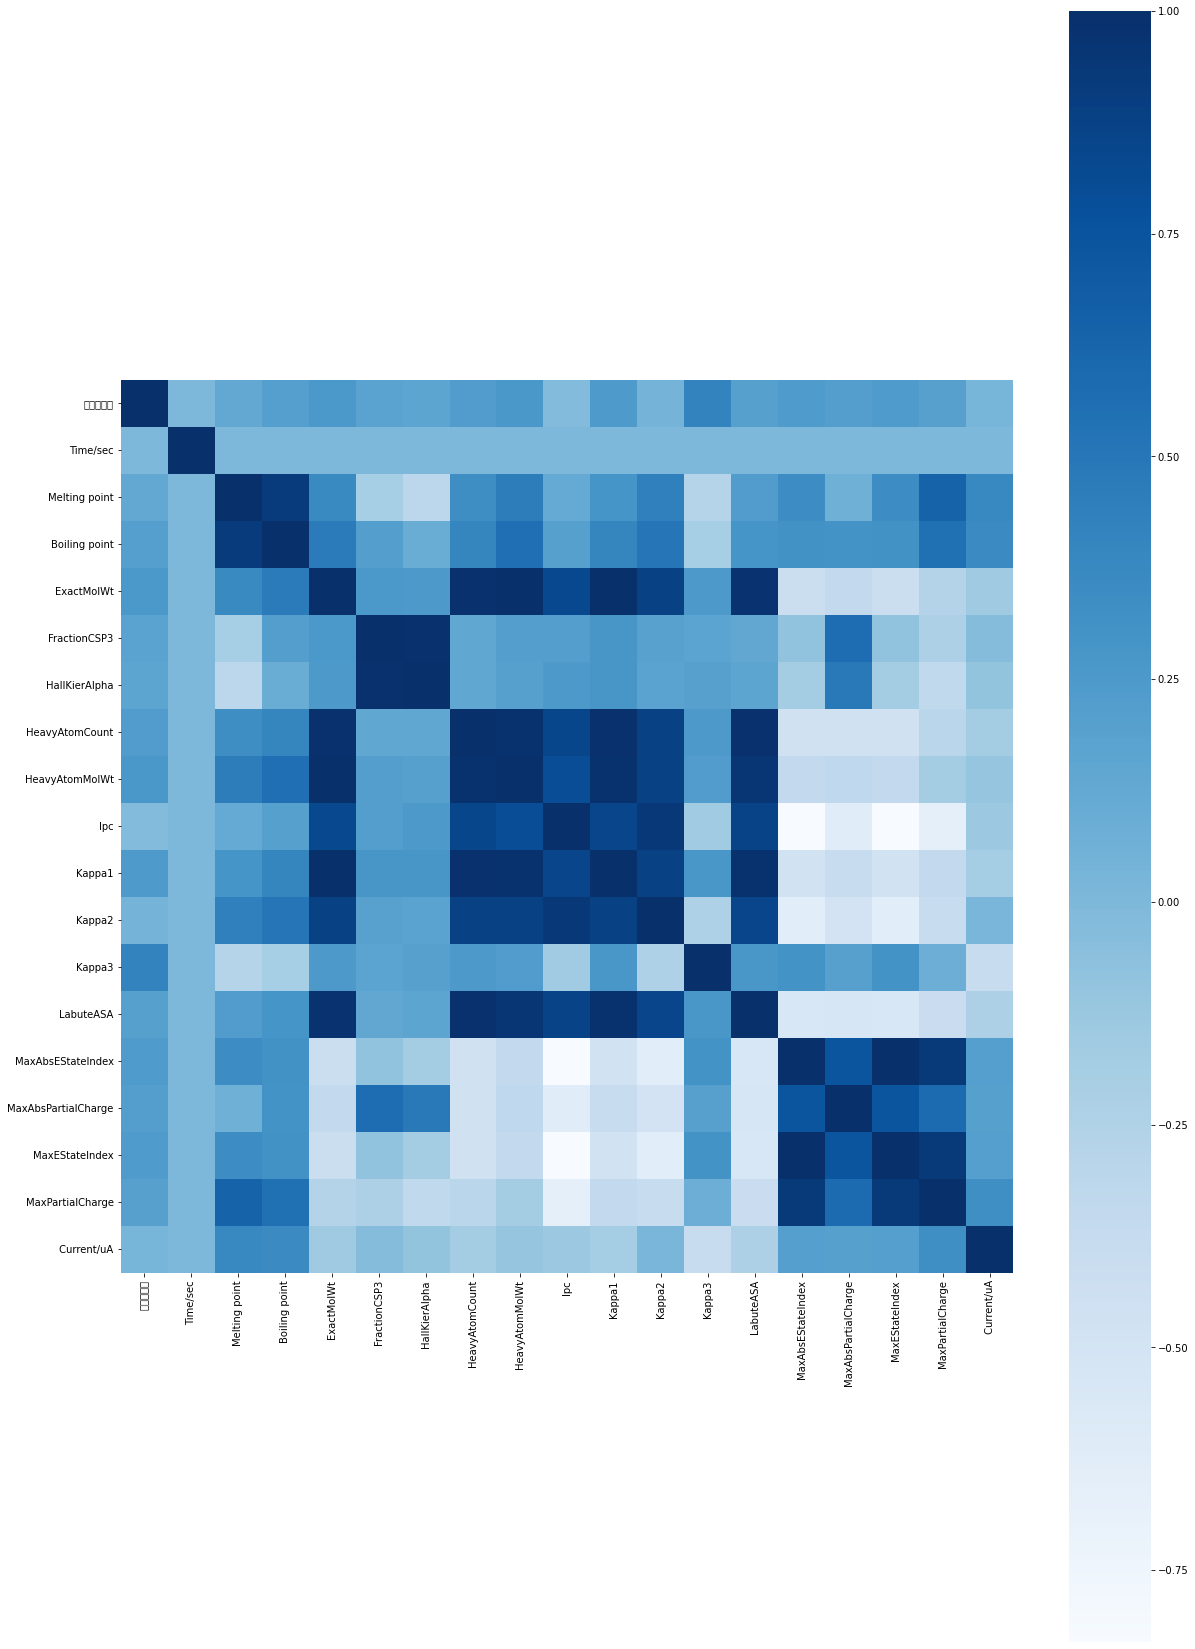

In [5]:
dataset= r'11.14-try.xlsx' #读取原始数据集,这里原文件丢失，使用了一个使用样本，后面Train.xlxs使用何牧的
data=pd.DataFrame(pd.read_excel(dataset))
featureData=data.iloc[:,:19]
corMat = DataFrame(featureData.corr())  #corr 求相关系数矩阵
print(corMat)
writer = pd.ExcelWriter('output.xlsx')
corMat.to_excel(writer,'Sheet1')
writer.save()
plt.figure(figsize=(20, 30))
sns.heatmap(corMat, annot=False, vmax=1, square=True, cmap="Blues",linewidths=0)
plot.show()

In [6]:
#读取文件
dataset= r'Train.xlsx' #读取特征工程后的Train数据集
data=pd.DataFrame(pd.read_excel(dataset))
dataset1= r'prediction.xlsx' #读取预测集
data1=pd.DataFrame(pd.read_excel(dataset1))

In [7]:
#画出所有特征关于目标值的相关系数排名
featureData=data.iloc[:,:15]
corMat = DataFrame(featureData.corr())  #corr 求相关系数矩阵
print(corMat)
writer = pd.ExcelWriter('output.xlsx')
corMat.to_excel(writer,'Sheet1')
writer.save()

                     Concentration      Time/sec  Melting point    ExactMolWt  \
Concentration         1.000000e+00 -3.634624e-17   1.317118e-01  2.575862e-01   
Time/sec             -3.634624e-17  1.000000e+00  -5.581703e-16 -4.820741e-16   
Melting point         1.317118e-01 -5.581703e-16   1.000000e+00  3.686622e-01   
ExactMolWt            2.575862e-01 -4.820741e-16   3.686622e-01  1.000000e+00   
FractionCSP3          1.821299e-01  7.087085e-16  -1.938902e-01  2.613787e-01   
Ipc                  -1.776508e-02 -2.814868e-16   1.174113e-01  8.311927e-01   
Kappa3                4.142078e-01 -9.613578e-18  -2.771722e-01  2.554343e-01   
MaxAbsEStateIndex     2.386768e-01  2.545759e-16   3.426825e-01 -4.143299e-01   
MaxAbsPartialCharge   2.140864e-01 -2.384243e-16   6.832394e-02 -3.527588e-01   
MinAbsEStateIndex    -4.370911e-01 -2.117794e-16  -4.843599e-01 -4.297887e-01   
MinPartialCharge     -2.140864e-01  2.384243e-16  -6.832394e-02  3.527588e-01   
MolLogP              -9.8266

In [8]:
#读取原数据集的描述符特征和目标值
X=data.values[:195,:14]
for i in range(X.shape[1]): #数据归一化
    X[:,[i]] = preprocessing.MinMaxScaler().fit_transform(X[:,[i]])
y=data.values[:195,14]

In [9]:
#读取预测集prediction的描述符特征
preX=data1.values[:,:]
for i in range(preX.shape[1]): #数据归一化
    preX[:,[i]] = preprocessing.MinMaxScaler().fit_transform(preX[:,[i]])

In [10]:
#读取自定义的训练集和测试集
X=data.values[:140,:14]
for i in range(X.shape[1]):
    X[:,[i]] = preprocessing.MinMaxScaler().fit_transform(X[:,[i]])
y=data.values[:140,14]
testX=data.values[140:195,:14]
for i in range(testX.shape[1]):
    testX[:,[i]] = preprocessing.MinMaxScaler().fit_transform(testX[:,[i]])
testy=data.values[140:195,14]

In [11]:
#选取4种分类算法
clf = RandomForestClassifier(max_depth=4, random_state=0, n_jobs=2)
#clf = svm.SVC(kernel='poly',gamma=5,degree=5)
#clf=ExtraTreesClassifier(n_estimators=10, max_depth=None,min_samples_split=2, random_state=0)
#kernel = 1.0 * RBF([1.0])
#clf=GaussianProcessClassifier(kernel=kernel, warm_start=True)

In [12]:
#使用KFold交叉验证
for nk in range(2,13):
 kfolder = KFold(n_splits=nk)
 score=0
 for train, test in kfolder.split(X,y):
   train_data = np.array(data)[train]
   test_data = np.array(data)[test]
   trany=train_data[:,14]
   tranx=train_data[:,:14]
   testx=test_data[:,:14]
   testy=test_data[:,14]
   clf.fit(tranx,trany)
   prey=clf.predict(testx)
   true=0
   for i in range(0,len(testy)):
     if prey[i]==testy[i]:
         true=true+1
   score=true/len(testy)+score
 print(score/nk)

0.7071428571428571
0.9209065679925995
0.9571428571428571
0.9357142857142857
0.9577294685990339
0.9500000000000001
0.8937908496732025
0.9495370370370372
0.95
0.9924242424242423
0.9785353535353535


In [13]:
#画出ROC曲线
y_score = clf.fit(X, y).predict_proba(testX)
fpr,tpr,threshold = roc_curve(testy, y_score[:, 1])
roc_auc = auc(fpr,tpr)
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
print(fpr)
print(tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [11, 55]

In [14]:
#画出混淆矩阵
clf.fit(X, y)
prey=clf.predict(testX)
true=0
for i in range(0,len(testy)):
 if prey[i]==testy[i]:
     true=true+1
print(true/55)
C = confusion_matrix(testy, prey, labels=[0,1])
plt.imshow(C, cmap=plt.cm.Blues)
indices = range(len(C))
plt.xticks(indices, [0, 1],fontsize=20)
plt.yticks(indices, [0, 1],fontsize=20)
plt.colorbar()
for first_index in range(len(C)):    #第几行
    for second_index in range(len(C)):    #第几列
        plt.text(first_index, second_index, C[first_index][second_index],fontsize=20,horizontalalignment='center')
plt.show()

0.12727272727272726


ValueError: Found input variables with inconsistent numbers of samples: [11, 55]